In [8]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')

from tmm.get_jacobi_n_adjoint import get_jacobi_free_form
from film import TwoMaterialFilm, FreeFormFilm, BaseFilm
from design import DesignForFilm

from analyze_utils.structure import plot_layer_thickness
from optimizer.adam import AdamFreeFormOptimizer, AdamThicknessOptimizer

import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

inc_ang = 0.
wls = np.linspace(500, 2000, 500)

#  make target film
# np.random.seed(1)
# d = np.random.random(15)
# d *= 1000. / d.sum()

# d = np.array([100, 100] * 3)
# target_film = TwoMaterialFilm('2', '1', 'SiO2', d)

np.random.seed(2)
d = np.random.random(6)
d *= 600 / d.sum()
target_film = TwoMaterialFilm('2', '1', 'SiO2', d)

target_film.add_spec_param(inc_ang, wls)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# thickness gd
np.random.seed(42)
init_layers = 100
d = np.random.random(init_layers) + 1.
d = d * 1000 / d.sum() # total gd = 1000 nm
rand_2m_gd_film = TwoMaterialFilm('1', '2', 'SiO2', d)
design = DesignForFilm(target_film, rand_2m_gd_film)

adam_d_optimizer = AdamThicknessOptimizer(
    design.film, 
    design.target_specs, 
    4000, 
    alpha=0.1, 
    record=True, 
    show=True,
)


In [64]:


def gd_one_ang(target_film: BaseFilm, film: FreeFormFilm):
    target_film = copy.deepcopy(target_film)
    target_film.remove_all_spec_param()
    target_film.add_spec_param(0., wls)
    adam_optimizer = AdamFreeFormOptimizer(
        film, 
        target_film.get_all_spec_list(), 
        500, 
        alpha=0.1, 
        beta1=0.9, 
        beta2=0.999, 
        record=True, 
        show=True, 
        n_min=1, 
        n_max=3, 
        batch_size_wl=100
    )
    films, losses = adam_optimizer()
    return losses, films

def gd_two_angs(target_film: BaseFilm, film: FreeFormFilm, alpha=0.3):
    target_film = copy.deepcopy(target_film)
    
    target_film.remove_all_spec_param()
    target_film.add_spec_param(45., wls) 
    target_film.add_spec_param(0., wls)
    
    film.remove_all_spec_param()
    film.add_spec_param(45., wls) 
    film.add_spec_param(0., wls)

    adam_optimizer = AdamFreeFormOptimizer(
        film, 
        target_film.get_all_spec_list(), 
        500, 
        alpha=alpha, 
        beta1=0.9, 
        beta2=0.999, 
        record=True, 
        show=True, 
        n_min=1, 
        n_max=3, # note that this constraint is extra info
        batch_size_wl=500,  
    )
    films, losses = adam_optimizer()
    return losses, films




In [ ]:

# free form gd
np.random.seed(42)
n_pert = np.random.random(1000) * 2 + 1 # in (1, 2)

# n = np.random.random(1000) + 1
free_film_target = FreeFormFilm(np.sin(np.linspace(0, 5 * np.pi, 1000)) + 2, 600., 'SiO2')
free_film = FreeFormFilm(n_pert, 600., 'SiO2')

gd_two_angs(free_film_target, free_film)
plot_layer_thickness(free_film)

film has no spec. use 1000 nm
film has no spec. use 1000 nm
film has no spec. use 1000 nm


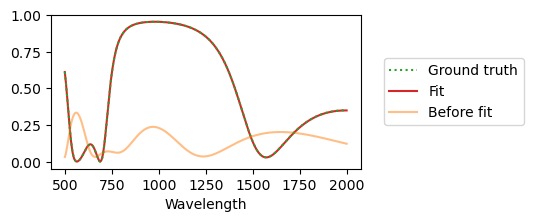

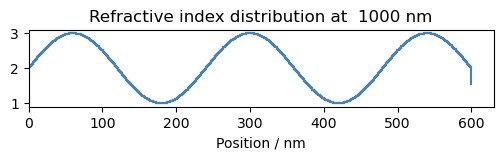

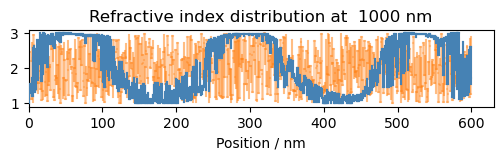

In [56]:
free_film_init = FreeFormFilm(n_pert, 600., 'SiO2')

fig, ax = plt.subplots(1, 1)
ax.plot(wls, free_film_target.get_spec(inc_ang, wls, ).get_R(), label='Ground truth', c='C2', ls=':', zorder=10)
ax.plot(wls, free_film.get_spec(inc_ang, wls, ).get_R(), label='Fit', c='C3')
ax.plot(wls, free_film_init.get_spec(inc_ang, wls, ).get_R(), label='Before fit', c='C1', alpha=0.5)
ax.legend(loc='center', bbox_to_anchor=(1.3, 0.5))
ax.set_xlabel('Wavelength')
# ax.set_ylabel('R')
fig.set_size_inches(4, 2)
fig.savefig('reverse_inhomogeneous_spectrum.png', dpi=300, bbox_inches='tight')


ax, fig = plot_layer_thickness(free_film_target)
fig.savefig('reverse_inhomogeneous_target_structure.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(1, 1)
plot_layer_thickness(free_film, fig=fig, ax=ax, zorder=10)
plot_layer_thickness(free_film_init, fig=fig, ax=ax, alpha=0.3, color='C1')
fig.savefig('reverse_inhomogeneous_fitted_structure.png', dpi=300, bbox_inches='tight')


In [ ]:


# fig, ax = plt.subplots(1, 1)
# ax.plot([0, 0], [1, 1], color='C0', label='Fitted')
# ax.plot([0, 0], [1, 1], color='C1', label='Randomly Initialized')
# ax.legend()


In [ ]:
# free form gd
np.random.seed(42)
n_pert = np.random.random(1000) * 2 + 1 # in (1, 2)

# n = np.random.random(1000) + 1
free_film_target = TwoMaterialFilm(3, 1, 'SiO2', np.array([2, 100, 200, 100, 198]))

n_init = np.zeros(600) + 1
n_init[100: 300] = 3
n_init[400: ] = 3
free_film = FreeFormFilm(n_init, 600., 'SiO2')

In [ ]:
gd_two_angs(free_film_target, free_film, alpha=0.1)

film has no spec. use 1000 nm
film has no spec. use 1000 nm
film has no spec. use 1000 nm


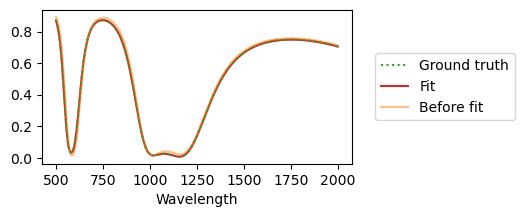

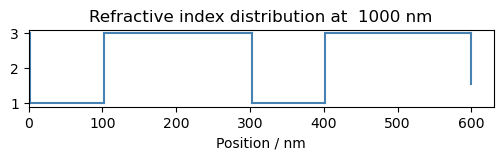

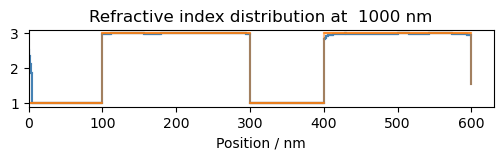

In [79]:
free_film_init = FreeFormFilm(n_init, 600., 'SiO2')

fig, ax = plt.subplots(1, 1)
ax.plot(wls, free_film_target.get_spec(inc_ang, wls, ).get_R(), label='Ground truth', c='C2', ls=':', zorder=10)
ax.plot(wls, free_film.get_spec(inc_ang, wls, ).get_R(), label='Fit', c='C3')
ax.plot(wls, free_film_init.get_spec(inc_ang, wls, ).get_R(), label='Before fit', c='C1', alpha=0.5)
ax.legend(loc='center', bbox_to_anchor=(1.3, 0.5))
ax.set_xlabel('Wavelength')
# ax.set_ylabel('R')
fig.set_size_inches(4, 2)
fig.savefig('reverse_unknown_spectrum.png', dpi=300, bbox_inches='tight')

ax, fig = plot_layer_thickness(free_film_target)
fig.savefig('reverse_unknown_target_structure.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(1, 1)
plot_layer_thickness(free_film, fig=fig, ax=ax, zorder=0)
plot_layer_thickness(free_film_init, fig=fig, ax=ax, alpha=0.5, color='C1')
fig.savefig('reverse_unknown_fitted_structure.png', dpi=300, bbox_inches='tight')

In [ ]:
losses, films = gd_two_angs(target_film, free_film)

working_film_save_dir = './films_double_specs'
with open(working_film_save_dir, 'wb') as  f:
    pickle.dump(films, f)

In [41]:
from analyze_utils.structure import diff_simple_film

with open(working_film_save_dir, 'rb') as f:
    films = pickle.load(f)
    
similarities = []

for film in films:
    similarities.append(diff_simple_film(target_film, film))
    


In [ ]:
fpath = './results/reverse_random_easy_2/45_deg/'


ax, fig = plot_layer_thickness(target_film)
fig.savefig(fpath + f'target.png', dpi=300, bbox_inches='tight')


plot_i = list(range(5)) + [100, 200, 500]
for i in plot_i[::-1]:
    f: BaseFilm = copy.deepcopy(films[i])
    d = f.get_d()
    sum = 0
    for j, di in enumerate(d):
        if sum > 600:
            break
        sum += di
    d = d[:j]

    f.update_d(d)
    ax, fig = plot_layer_thickness(f)
    ax.set_title(f'step {i}')
    fig.savefig(fpath + f'step_{i}.png', dpi=300, bbox_inches='tight')

    ax, fig = plot_layer_thickness(films[i])
    ax.set_title(f'step {i}')
    fig.savefig(fpath + f'all_depth_step_{i}.png', dpi=300, bbox_inches='tight')


# plot specs# plot specs
spec_param_ls = [[0., wls], [30., wls], [60., wls]]
fig, axes = plt.subplots(
    1, 
    len(spec_param_ls), 
    sharey=True, 
)
axes = [axes] if isinstance(axes, plt.Axes) else axes # special case: 1 spec
axes[0].set_ylabel('R')
for ax, spec_arg in zip(axes, spec_param_ls):
    ax.plot(
        wls, 
        target_film.get_spec(*spec_arg).get_R(), 
        label='target'
    )
    ax.plot(
        wls, 
        free_film.get_spec(*spec_arg).get_R(), 
        label='design'
    )
    ax.set_title(f'inc at {spec_arg[0]}')
    ax.set_xlabel('wl / nm')
    ax.legend()
fig.tight_layout()
fig.savefig(fpath + 'spec.png', dpi=300)


fig, ax = plt.subplots(1, 1)
ax.plot(losses, label='losses')
ax.set_xlabel('step')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.legend(loc='upper right')

ax2 = ax.twinx()
ax2.plot(similarities, label='dif', c='orange')
ax2.set_ylabel('dif')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper left')
fig.savefig(fpath + 'training.png', dpi=300)


(<AxesSubplot: title={'center': 'refractive index distribution at  1252 nm'}, xlabel='position / nm'>,
 <Figure size 600x100 with 1 Axes>)

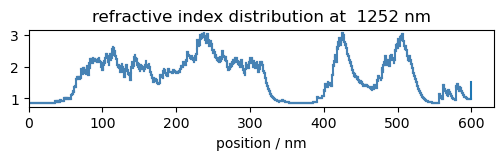

In [35]:
def equiv_n(x, window):
    def avg(x):
        return np.sqrt(np.square(x).mean())
    for i in range(x.shape[0] - window):
        x[i: i + window] = avg(x[i: i + window])
    for i in range(x.shape[0] - window, x.shape[0]):
        x[i:] = avg(x[i:])
    return x

film = copy.deepcopy(films[-1])
n = films[-1].get_n()
film.update_n(equiv_n(n, 10))
plot_layer_thickness(film)